## Setup

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

### Import

In [2]:
loan_df = pd.read_csv('loan_data.csv', index_col=0)

In [3]:
# Remove rows with missing data for simplicity
loan_df = loan_df.dropna(axis=0)
print(f"{loan_df.shape[0]} rows remaining",
      f"with {loan_df.shape[1] - 1} features")

480 rows remaining with 11 features


In [4]:
X = loan_df.drop('Loan_Status', axis=1)
y = loan_df['Loan_Status']

## Preprocessing

### Predictor Encoding

In [5]:
# NB: We can encode this variable as an ordinal despite the level '3+'
# since the tree-based model we will use has no notion of linearity
X['Dependents'] = X['Dependents'].str.replace('+', '').astype('int')

In [6]:
X_cat = X.select_dtypes(include='object')
X_num = X.select_dtypes(exclude='object')

In [7]:
enc = OneHotEncoder(drop='first', sparse=False)
X_enc = enc.fit_transform(X_cat)
X_enc = np.concatenate([X_enc, X_num.to_numpy()], axis=1)

### Response Encoding

In [8]:
y = (y == 'Y').astype('int')

### Train-test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=1729
)

## Modelling

### Training

In [10]:
rfm = RandomForestClassifier(max_depth=3, 
                             random_state=1729)
rfm.fit(X_train, y_train);

### Prediction

In [11]:
y_pred = rfm.predict(X_test)
y_score = rfm.predict_proba(X_test)

In [23]:
pd.concat([y_test, pd.DataFrame(y_pred,
                                columns=['Prediction'],
                                index=y_test.index)],
          axis=1).head()

,Loan_Status,Prediction
Loan_ID,,
LP001529,1,1
LP001938,0,0
LP001702,0,1
LP002600,1,1
LP001482,1,1


### Evaluation

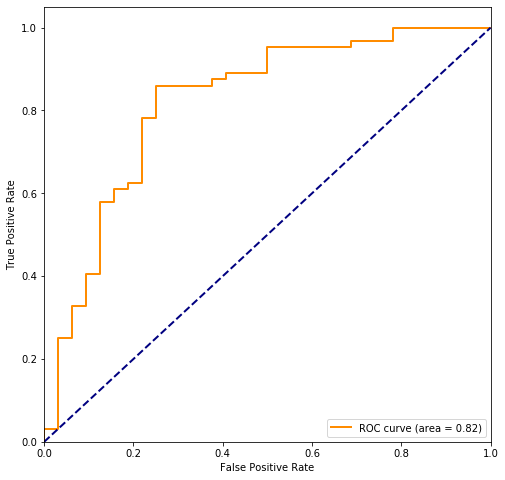

In [12]:
# ROC-curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")
plt.show()

## Shapley Values

In [117]:
i = 123
col_names = np.concatenate((enc.get_feature_names(X_cat.columns), X_num.columns))

In [120]:
# ith person in training set
pd.DataFrame(X_train[i].reshape((1, 12)), columns=col_names)

,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,6400.0,7250.0,180.0,360.0,0.0


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


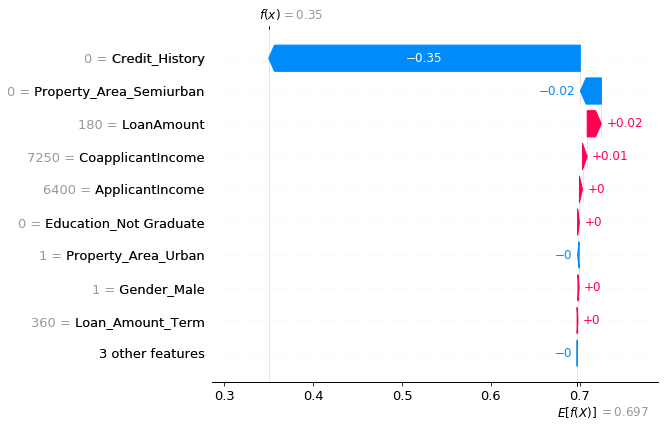

In [122]:
explainer = shap.TreeExplainer(rfm)
shap_values = explainer.shap_values(X_train)
shap.waterfall_plot(explainer.expected_value[1], shap_values[1][i],
                features=X_train[i],
                feature_names=col_names)